In [3]:
# PyTorch 및 관련 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 데이터 전처리 및 로더 관련 모듈
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# 기타 유틸리티
import os
import numpy as np
import matplotlib.pyplot as plt



In [4]:
import os
import urllib.request
import zipfile

# 데이터셋 다운로드 및 압축 해제
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_filename = 'cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(_URL, zip_filename)

# 압축 해제: 현재 작업 디렉토리에 압축이 풀립니다.
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()

# 데이터셋 경로 설정 (압축이 풀린 폴더)
PATH = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# training 데이터셋 내 고양이와 강아지 이미지 폴더
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation 데이터셋 내 고양이와 강아지 이미지 폴더
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print("Train cats directory:", train_cats_dir)
print("Train dogs directory:", train_dogs_dir)
print("Validation cats directory:", validation_cats_dir)
print("Validation dogs directory:", validation_dogs_dir)


Train cats directory: /content/cats_and_dogs_filtered/train/cats
Train dogs directory: /content/cats_and_dogs_filtered/train/dogs
Validation cats directory: /content/cats_and_dogs_filtered/validation/cats
Validation dogs directory: /content/cats_and_dogs_filtered/validation/dogs


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)


total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
batch_size = 32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

validation_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])


In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# ImageFolder를 사용하여 데이터셋 생성 (하위 폴더명이 클래스가 됨)
train_data = ImageFolder(root=train_dir, transform=train_transforms)
val_data = ImageFolder(root=validation_dir, transform=validation_transforms)

# DataLoader를 이용하여 배치 단위로 데이터 로딩
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print("Total training images:", len(train_data))
print("Total validation images:", len(val_data))


Total training images: 2000
Total validation images: 1000


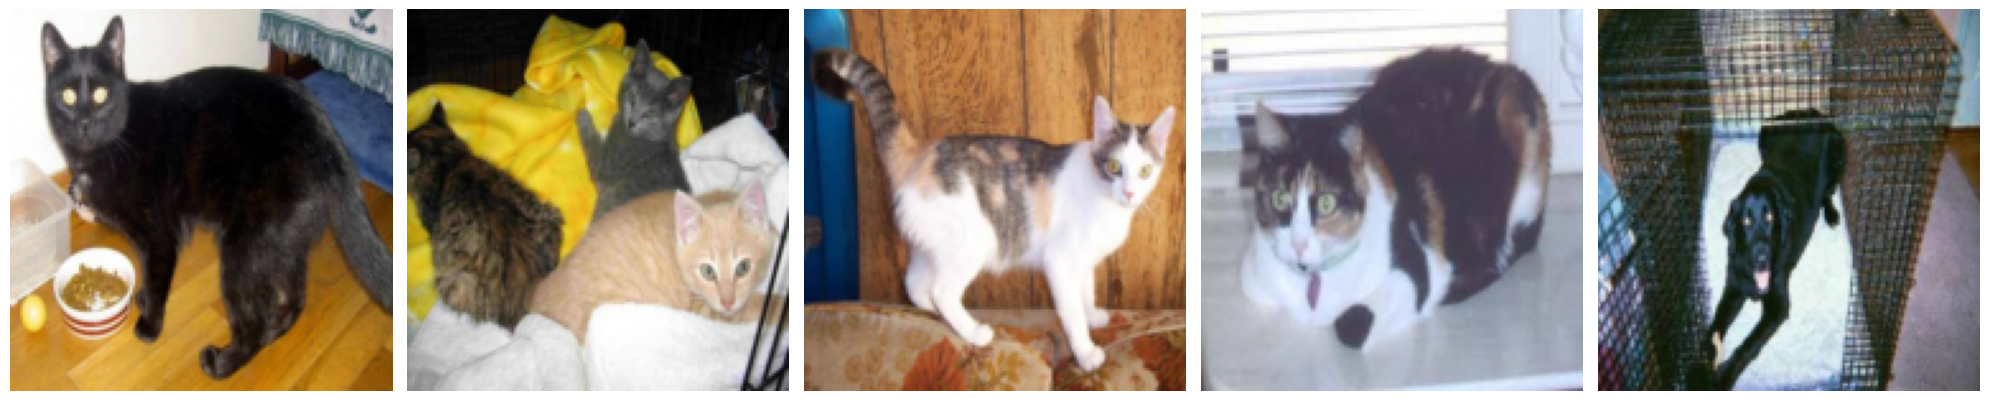

In [9]:
# DataLoader에서 배치 데이터 추출
sample_training_images, _ = next(iter(train_loader))

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # 텐서를 [H, W, C] 형태로 변환
        npimg = img.permute(1, 2, 0).numpy()
        ax.imshow(npimg)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

In [10]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, img_height, img_width):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # Conv2D(16, 3, padding='same', activation='relu')
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            # MaxPooling2D()
            nn.MaxPool2d(kernel_size=2),

            # Conv2D(32, 3, padding='same', activation='relu')
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # MaxPooling2D()
            nn.MaxPool2d(kernel_size=2),

            # Conv2D(64, 3, padding='same', activation='relu')
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # MaxPooling2D()
            nn.MaxPool2d(kernel_size=2)
        )
        # 계산: 3번의 max pooling → 가로세로가 각각 /8 됨
        fc_input_dim = 64 * (img_height // 8) * (img_width // 8)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()  # 이진 분류이므로 sigmoid 사용
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 모델 생성 (이미지 크기를 위에서 정의한 IMG_HEIGHT, IMG_WIDTH로 전달)
model = CNNModel(IMG_HEIGHT, IMG_WIDTH)
print(model)


CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20736, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [11]:
import torch.optim as optim
import torch.nn as nn

# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # 모델의 마지막에 Sigmoid를 사용했으므로 BCE 손실 사용

# 모델 요약 출력 (torchsummary 사용)
!pip install torchsummary  # Colab에서 torchsummary가 설치되어 있지 않다면 설치
from torchsummary import summary
summary(model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
              ReLU-2         [-1, 16, 150, 150]               0
         MaxPool2d-3           [-1, 16, 75, 75]               0
            Conv2d-4           [-1, 32, 75, 75]           4,640
              ReLU-5           [-1, 32, 75, 75]               0
         MaxPool2d-6           [-1, 32, 37, 37]               0
            Conv2d-7           [-1, 64, 37, 37]          18,496
              ReLU-8           [-1, 64, 37, 37]               0
         MaxPool2d-9           [-1, 64, 18, 18]               0
          Flatten-10                [-1, 20736]               0
           Linear-11                  [-1, 512]      10,617,344
             ReLU-12                  [-1, 512]               0
           Linear-13                    [-1, 1]             513
          Sigmoid-14                   

In [12]:
# history를 저장할 딕셔너리
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    # 학습 단계
    model.train()  # 모델을 학습 모드로 전환
    running_loss = 0.0
    running_corrects = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        # BCE 손실을 위해 label의 형태를 (batch_size, 1)로 변경 (TensorFlow의 binary_crossentropy와 동일)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # 예측: sigmoid 출력이 0.5 이상이면 1, 그렇지 않으면 0
        preds = (outputs > 0.5).float()
        running_corrects += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    epoch_loss = running_loss / total_train_samples
    epoch_acc = running_corrects / total_train_samples
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # 검증 단계
    model.eval()  # 평가 모드로 전환
    val_running_loss = 0.0
    val_running_corrects = 0
    total_val_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            preds = (outputs > 0.5).float()
            val_running_corrects += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss = val_running_loss / total_val_samples
    val_acc = val_running_corrects / total_val_samples
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Epoch [1/15]
Train Loss: 0.6937, Train Acc: 0.5110
Val   Loss: 0.6823, Val   Acc: 0.5300
Epoch [2/15]
Train Loss: 0.6723, Train Acc: 0.5825
Val   Loss: 0.6650, Val   Acc: 0.5970
Epoch [3/15]
Train Loss: 0.6167, Train Acc: 0.6705
Val   Loss: 0.6430, Val   Acc: 0.6500
Epoch [4/15]
Train Loss: 0.5634, Train Acc: 0.7110
Val   Loss: 0.6041, Val   Acc: 0.6770
Epoch [5/15]
Train Loss: 0.5091, Train Acc: 0.7485
Val   Loss: 0.6416, Val   Acc: 0.6640
Epoch [6/15]
Train Loss: 0.4463, Train Acc: 0.7950
Val   Loss: 0.5931, Val   Acc: 0.7130
Epoch [7/15]
Train Loss: 0.3849, Train Acc: 0.8240
Val   Loss: 0.6221, Val   Acc: 0.7000
Epoch [8/15]
Train Loss: 0.2857, Train Acc: 0.8835
Val   Loss: 0.6574, Val   Acc: 0.7200
Epoch [9/15]
Train Loss: 0.1906, Train Acc: 0.9240
Val   Loss: 0.7345, Val   Acc: 0.7240
Epoch [10/15]
Train Loss: 0.1272, Train Acc: 0.9535
Val   Loss: 0.8896, Val   Acc: 0.7180
Epoch [11/15]
Train Loss: 0.0794, Train Acc: 0.9725
Val   Loss: 1.0431, Val   Acc: 0.7020
Epoch [12/15]
Train

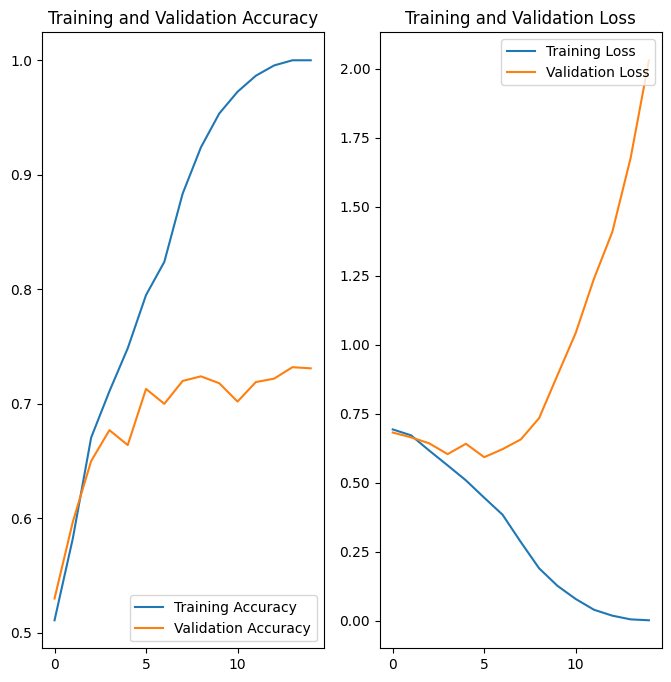

In [13]:
# history 딕셔너리에서 값들을 추출
acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 학습용 데이터 전처리: 리사이즈, horizontal flip, 텐서 변환 (이미지가 [0,1] 범위로 변환됨)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),  # horizontal flip 증강
    transforms.ToTensor()
])

# ImageFolder를 사용해 데이터셋 생성 (디렉토리 구조에 따라 클래스가 자동 할당됨)
train_data = ImageFolder(root=train_dir, transform=train_transforms)

# DataLoader를 사용해 배치 단위로 데이터 로딩
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

print("Total training images:", len(train_data))


Total training images: 2000


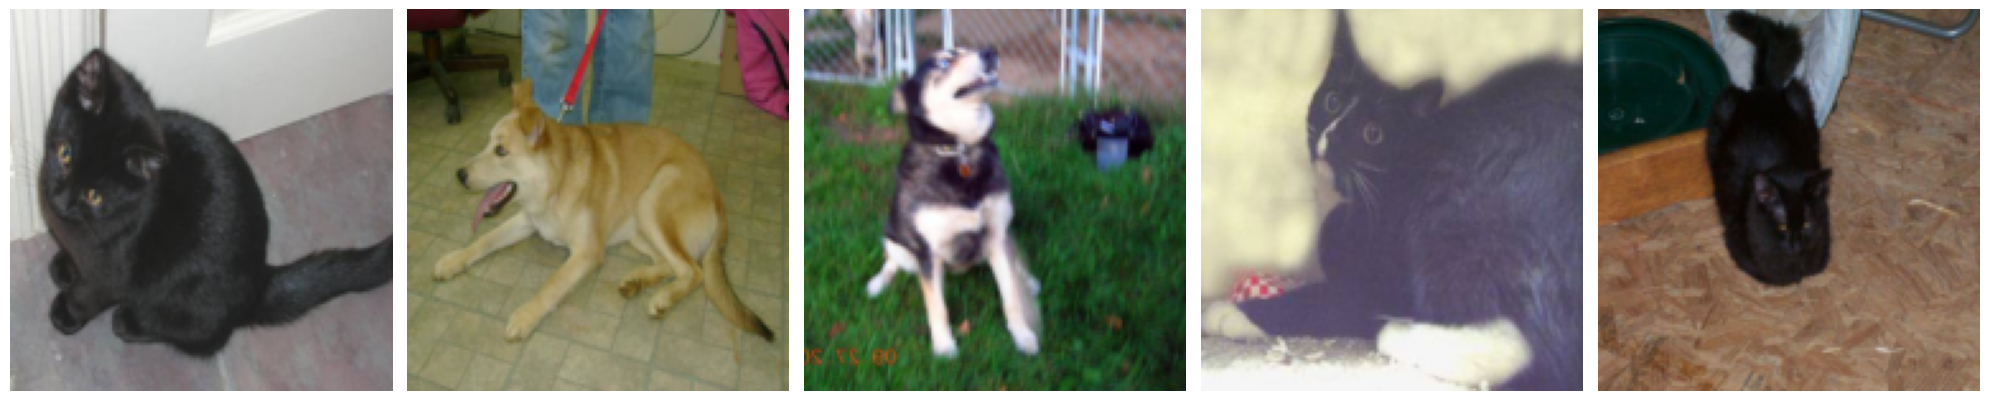

In [15]:
# 한 배치에서 데이터를 추출
batch = next(iter(train_loader))
images, labels = batch  # images: [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]

# 첫 5개 이미지 선택
augmented_images = images[:5]

# 앞서 정의한 plotImages 함수를 사용해 시각화
plotImages(augmented_images)


In [18]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    # RandomAffine를 이용하여 줌 효과 적용: degrees=0으로 회전은 적용하지 않고,
    # scale 범위를 (0.5, 1.5)로 지정하여 원본 이미지 대비 50% 축소부터 150% 확대까지 적용
    transforms.RandomAffine(degrees=0, scale=(0.5, 1.5)),
    transforms.ToTensor()
])

# ImageFolder를 사용하여 데이터셋 생성 (하위 폴더명이 클래스 이름으로 자동 할당됨)
train_data = ImageFolder(root=train_dir, transform=train_transforms)

# DataLoader를 사용해 배치 단위로 데이터 로드 (shuffle=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

print("Total training images:", len(train_data))


Total training images: 2000


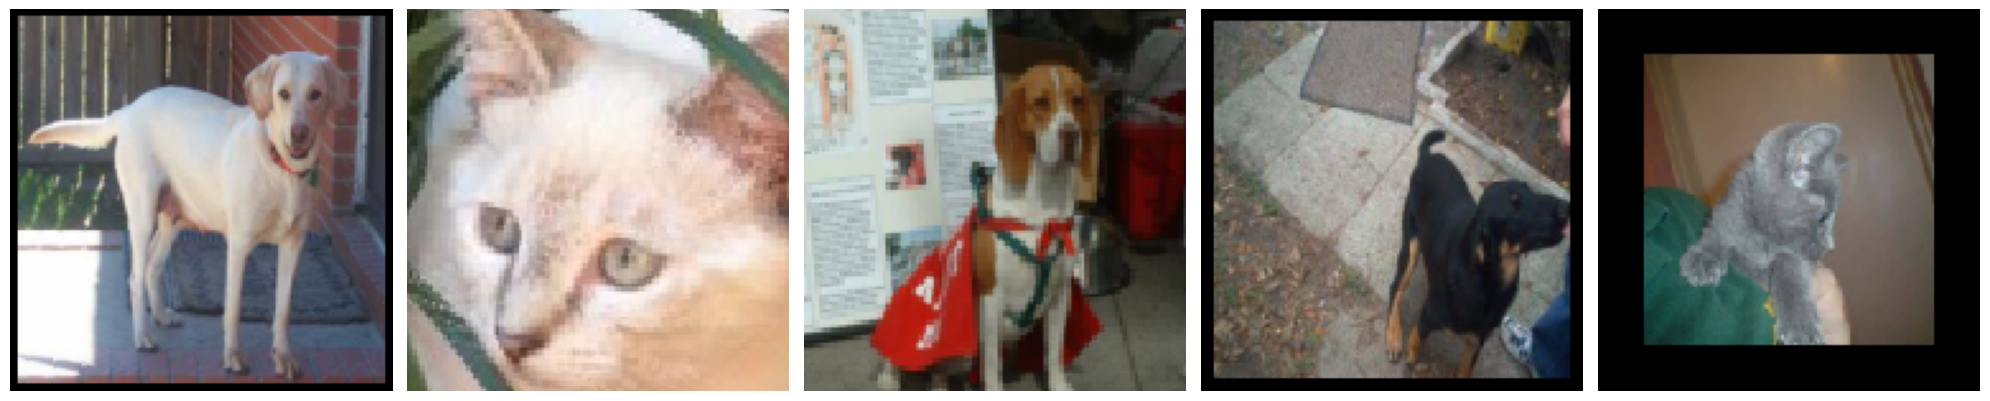

In [20]:
# DataLoader에서 한 배치를 추출합니다.
batch = next(iter(train_loader))
images, labels = batch  # images: [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]

# 첫 5개의 이미지를 선택합니다.
augmented_images = images[:5]

# 시각화 함수 호출 (plotImages 함수는 이전에 정의한 대로 이미지 텐서를 [H, W, C]로 변환 후 출력합니다)
plotImages(augmented_images)


In [22]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 학습용 데이터 전처리 (augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomAffine(
        degrees=45,                   # rotation_range=45
        translate=(0.15, 0.15),       # width_shift_range와 height_shift_range 0.15
        scale=(0.5, 1.5)              # zoom_range=0.5 → scale 범위 [0.5, 1.5]
    ),
    transforms.RandomHorizontalFlip(),  # horizontal_flip=True
    transforms.ToTensor()                 # ToTensor()가 이미 [0,1] 범위로 변환함
])

# ImageFolder를 사용해 데이터셋 생성 (하위 폴더명이 클래스 이름이 됨)
train_data = ImageFolder(root=train_dir, transform=train_transforms)

# DataLoader를 사용하여 배치 단위로 데이터 로딩 (shuffle=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

print("Total training images:", len(train_data))


Total training images: 2000


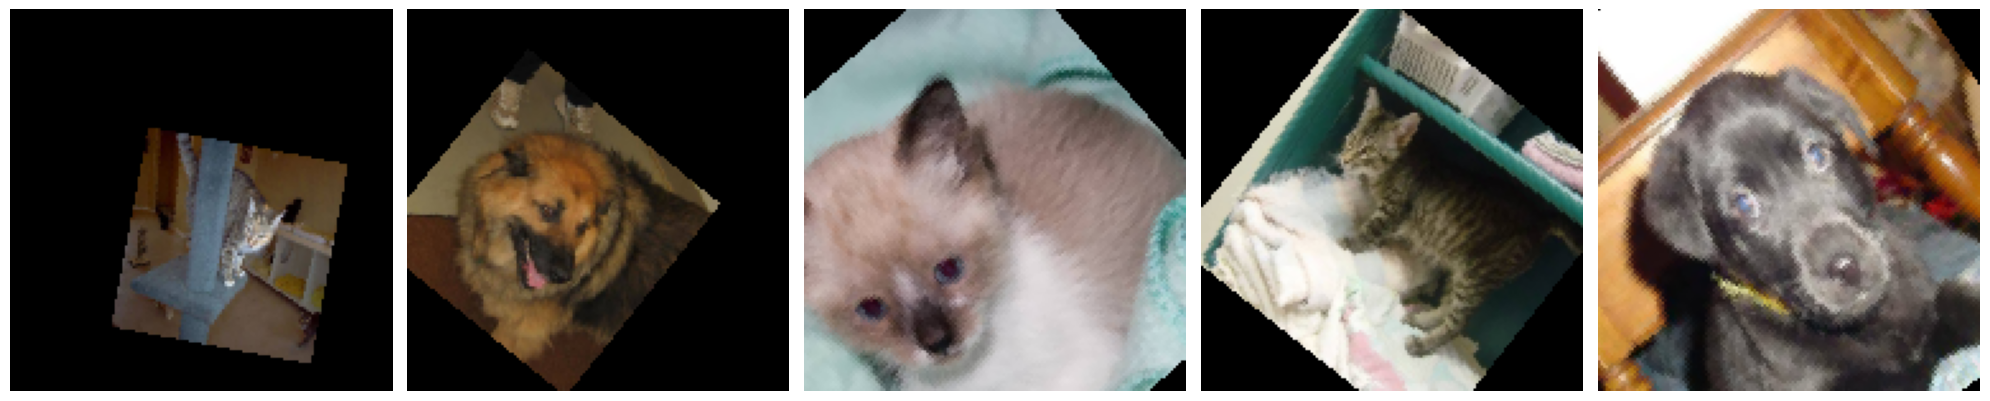

In [23]:
# DataLoader에서 한 배치를 추출합니다.
batch = next(iter(train_loader))
images, labels = batch  # images: [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]

# 첫 5개의 이미지를 선택합니다.
augmented_images = images[:5]

# 앞서 정의한 plotImages 함수를 사용하여 시각화합니다.
plotImages(augmented_images)


In [24]:
import torch
import torch.nn as nn

class CNNNew(nn.Module):
    def __init__(self, img_height, img_width):
        super(CNNNew, self).__init__()
        self.features = nn.Sequential(
            # 첫 번째 블록: Conv2D(16, 3, padding='same', activation='relu') -> MaxPooling2D() -> Dropout(0.2)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 이미지 크기를 1/2로 축소
            nn.Dropout(0.2),

            # 두 번째 블록: Conv2D(32, 3, padding='same', activation='relu') -> MaxPooling2D()
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 세 번째 블록: Conv2D(64, 3, padding='same', activation='relu') -> MaxPooling2D() -> Dropout(0.2)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
        )
        # Flatten 전에 들어가는 feature map의 크기 계산: 채널 수 64, 가로세로 크기는 1/8로 줄어듦
        fc_input_dim = 64 * (img_height // 8) * (img_width // 8)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()  # 이진 분류이므로 sigmoid 활성화
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 모델 생성 (예: IMG_HEIGHT=150, IMG_WIDTH=150)
model_new = CNNNew(IMG_HEIGHT, IMG_WIDTH)
print(model_new)


CNNNew(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20736, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [25]:
import torch.optim as optim
import torch.nn as nn

# 옵티마이저와 손실 함수 정의 (binary_crossentropy는 nn.BCELoss 사용, 단 모델 마지막에 Sigmoid가 있으므로)
optimizer_new = optim.Adam(model_new.parameters(), lr=0.001)
criterion_new = nn.BCELoss()

# 모델 구조 확인을 위해 torchsummary를 사용할 수 있습니다.
!pip install torchsummary  # Colab 환경에서 torchsummary가 설치되어 있지 않다면 설치
from torchsummary import summary
summary(model_new, input_size=(3, IMG_HEIGHT, IMG_WIDTH))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
              ReLU-2         [-1, 16, 150, 150]               0
         MaxPool2d-3           [-1, 16, 75, 75]               0
           Dropout-4           [-1, 16, 75, 75]               0
            Conv2d-5           [-1, 32, 75, 75]           4,640
              ReLU-6           [-1, 32, 75, 75]               0
         MaxPool2d-7           [-1, 32, 37, 37]               0
            Conv2d-8           [-1, 64, 37, 37]          18,496
              ReLU-9           [-1, 64, 37, 37]               0
        MaxPool2d-10           [-1, 64, 18, 18]               0
          Dropout-11           [-1, 64, 18, 18]               0
          Flatten-12                [-1, 20736]               0
           Linear-13                  [-1, 512]      10,617,344
             ReLU-14                  [

In [ ]:
# history를 저장할 딕셔너리
history_new = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(epochs):
    model_new.train()  # 학습 모드
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    # 학습 단계
    for images, labels in train_loader:
        images = images.to(device)
        # BCE 손실 계산을 위해 라벨을 float 타입의 (batch, 1) 형태로 변환
        labels = labels.to(device).float().unsqueeze(1)

        optimizer_new.zero_grad()
        outputs = model_new(images)
        loss = criterion_new(outputs, labels)
        loss.backward()
        optimizer_new.step()

        running_loss += loss.item() * images.size(0)
        # 출력이 sigmoid를 통과했으므로 0.5 기준으로 예측
        preds = (outputs > 0.5).float()
        running_corrects += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects / total_train
    history_new['train_loss'].append(epoch_loss)
    history_new['train_acc'].append(epoch_acc)

    # 검증 단계
    model_new.eval()  # 평가 모드
    val_running_loss = 0.0
    val_running_corrects = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model_new(images)
            loss = criterion_new(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            val_running_corrects += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_running_loss / total_val
    val_acc = val_running_corrects / total_val
    history_new['val_loss'].append(val_loss)
    history_new['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


Epoch [1/15]
Train Loss: 0.7112, Train Acc: 0.4900
Val   Loss: 0.6932, Val   Acc: 0.5000
Epoch [2/15]
Train Loss: 0.6933, Train Acc: 0.4960
Val   Loss: 0.6931, Val   Acc: 0.5000
Epoch [3/15]
Train Loss: 0.6932, Train Acc: 0.4955
Val   Loss: 0.6931, Val   Acc: 0.5220
Epoch [4/15]
Train Loss: 0.6932, Train Acc: 0.4990
Val   Loss: 0.6930, Val   Acc: 0.5340


In [ ]:
# history_new 딕셔너리에서 값들을 추출
acc = history_new['train_acc']
val_acc = history_new['val_acc']
loss = history_new['train_loss']
val_loss = history_new['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import torchvision.models as models

# 사전 학습된 VGG19 모델 불러오기
vgg = models.vgg19(pretrained=True)

# VGG19의 feature extractor 부분만 사용 (fully connected layers 제거)
vgg_features = vgg.features

# vgg_features는 이제 입력 크기가 (3, IMG_HEIGHT, IMG_WIDTH)인 이미지를 받아서 특징 맵을 추출합니다.
print(vgg_features)


In [ ]:
import torch.nn as nn
import torchvision.models as models

# 사전 학습된 VGG19 모델 불러오기 (pretrained=True)
vgg = models.vgg19(pretrained=True)
vgg_features = vgg.features  # fully connected 계층 없이 feature extractor만 사용

# VGG19의 파라미터는 고정하고 싶다면, 아래와 같이 설정할 수 있습니다.
for param in vgg_features.parameters():
    param.requires_grad = False

class VGGTransfer(nn.Module):
    def __init__(self, feature_extractor):
        super(VGGTransfer, self).__init__()
        self.features = feature_extractor
        # GlobalAveragePooling2D와 동일한 역할: AdaptiveAvgPool2d를 이용해 (1,1)로 축소
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # VGG19의 마지막 convolutional layer의 출력 채널은 512입니다.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1),
            nn.Sigmoid()  # 이진 분류용
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# 모델 생성
model_vgg = VGGTransfer(vgg_features)
print(model_vgg)


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Adam 옵티마이저 정의 (학습률 0.0001)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.0001)
# 이진 분류 손실 함수 (모델의 마지막에 Sigmoid가 있으므로 BCE 손실 사용)
criterion_vgg = nn.BCELoss()

# 모델 요약 확인을 위해 torchsummary 사용
!pip install torchsummary  # Colab에서 torchsummary가 설치되어 있지 않다면 설치
from torchsummary import summary
summary(model_vgg, input_size=(3, IMG_HEIGHT, IMG_WIDTH))


In [ ]:
history = model_vgg.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    verbose=2
)

In [ ]:
# history_vgg 딕셔너리에서 값들을 추출
acc = history_vgg['train_acc']
val_acc = history_vgg['val_acc']
loss = history_vgg['train_loss']
val_loss = history_vgg['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
